<a href="https://colab.research.google.com/github/nicolste1/Mesterbakeren_sales_prediction/blob/main/Python_kode_for_Dataforberedelse_til_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TTing å legge til
-


*   Ordentlig bruk av holyday funksjon DONE
*   Klare å mestre det ukentlige variasjonene HALVEIS
*   Skole fri DONE
*   5. Kryssvalidering for Hyperparameterjustering 🧪
For å finne de beste verdiene for parametere som changepoint_prior_scale og seasonality_prior_scale, bør du bruke Prophets innebygde kryssvalideringsfunksjoner. Dette hjelper deg å evaluere modellens ytelse på usett data.






# Task
Refactor the data preparation logic from cell `nP-2FoFaGs0U` into a function `prepare_sales_data("MB salg.xlsx", "Sheet1")` that returns a prepared DataFrame, then use this function in the main part of the script to get the data, split it into training data (before 2025) and test data (2025), initialize and train a Prophet model on the training data without regressors, generate predictions for the test period, and visualize the results.

## Refaktor dataforberedelse

### Subtask:
Flytt logikken fra celle `nP-2FoFaGs0U` inn i en funksjon, for eksempel `prepare_sales_data(file_path, sheet_name)`. Denne funksjonen skal returnere den klargjorte `df_prepared` DataFrame-en.


Legg til en funksjon som ser etter holydays da etter dager som viker fra det vanlige mønsteret enkle holydays er vanlig røde dager pluss dagene rundt. Men andre "heliig dager" kan være feks norwaycup i oslo eller millitærøvelse i kirknes. Derav et program som finner holydays.


Hvordan håndtere helligdager som varierer fra år til år (f.eks. påske) 🐰
For å inkludere helligdager som varierer i dato, som påske, må du generere en liste over disse datoene for alle årene som dekkes av treningsdataene dine, pluss alle årene du ønsker å prognostisere for.

Her er en generell tilnærming for å gjøre dette:

Generer påskedatoer programmatisk: Siden påskedatoer følger et komplekst mønster, er det best å bruke et bibliotek eller en funksjon som kan beregne dem for deg. pandas eller dateutil kan hjelpe med dette, men det finnes også spesifikke algoritmer eller forhåndsdefinerte lister. For enkelhets skyld kan du også finne kalenderdata online.

Lag en DataFrame for helligdagene: Konstruer en pandas.DataFrame med kolonnene holiday og ds (dato), og eventuelt lower_window og upper_window for å fange opp effekter før eller etter selve helligdagen.

In [23]:
import pandas as pd

def prepare_sales_data(file_path, sheet_name, verbose=True):
    """
    Prepares sales data from an Excel file for Prophet modeling.

    Args:
        file_path (str): The path to the Excel file.
        sheet_name (str): The name of the sheet to read from.
        verbose (bool): If True, print progress messages. Defaults to True.

    Returns:
        pd.DataFrame: The prepared DataFrame with 'ds', 'y', and 'Butikk_ID' columns,
                      or an empty DataFrame if an error occurred.
    """
    df_full_raw = None
    try:
        df_full_raw = pd.read_excel(file_path, sheet_name=sheet_name, header=None)
        if verbose:
            print(f"Excel file '{file_path}' loaded.")
    except FileNotFoundError:
        print(f"Error: '{file_path}' not found.") # Always print errors
        return pd.DataFrame(columns=['ds', 'y', 'Butikk_ID'])
    except Exception as e:
        print(f"An error occurred while loading the Excel file: {e}") # Always print errors
        return pd.DataFrame(columns=['ds', 'y', 'Butikk_ID'])

    if df_full_raw is not None and not df_full_raw.empty:
        # --- Identify date columns and sales data rows ---
        # Assuming dates are in the SECOND row (index 1), from column 3 onwards.
        # Assuming store data starts from row 4 (index 3) onwards.
        # Assuming the first store data is in row 5 (index 4) in the raw data.

        # --- Manual Date Range Creation ---
        # Define start and end dates manually based on the file content structure
        # Assuming the start date is in cell D2 (column 3, row 1) and end date in cell BW2 (column 1324, row 1)
        # Based on the printout, the first date is in column 3, row 1 (index 1), and the last date is in column 1324, row 1 (index 1)
        # Let's try to extract the start and end dates from the raw data if available, otherwise use hardcoded fallbacks.
        start_date_from_file = None
        end_date_from_file = None

        try:
             # Attempt to read the start date from the specified cell (D2 -> iloc[1, 3])
            raw_start_date_value = df_full_raw.iloc[1, 3]
            # Attempt to read the end date from the last date column (iloc[1, -1])
            raw_end_date_value = df_full_raw.iloc[1, -1]

            # Try to parse these values into datetime objects
            if pd.notna(raw_start_date_value):
                # Handle potential datetime objects or strings
                if isinstance(raw_start_date_value, pd.Timestamp):
                    start_date_from_file = raw_start_date_value.strftime('%Y-%m-%d')
                else:
                    # Try parsing as string, assuming day/month/year format
                    try:
                        start_date_from_file = pd.to_datetime(str(raw_start_date_value).split(' ')[0], format='%d/%m/%Y').strftime('%Y-%m-%d')
                    except:
                         print(f"Warning: Could not parse start date '{raw_start_date_value}'. Using fallback.") # Always print warnings
                         start_date_from_file = '2021-12-09' # Fallback

            if pd.notna(raw_end_date_value):
                 if isinstance(raw_end_date_value, pd.Timestamp):
                    end_date_from_file = raw_end_date_value.strftime('%Y-%m-%d')
                 else:
                    try:
                        end_date_from_file = pd.to_datetime(str(raw_end_date_value).split(' ')[0], format='%d/%m/%Y').strftime('%Y-%m-%d')
                    except:
                         print(f"Warning: Could not parse end date '{raw_end_date_value}'. Using fallback.") # Always print warnings
                         end_date_from_file = '2025-07-22' # Fallback

        except IndexError:
            print("Warning: Could not access expected date cells. Using fallback dates.") # Always print warnings
            start_date_from_file = '2021-12-09'
            end_date_from_file = '2025-07-22'
        except Exception as e:
             print(f"An unexpected error occurred while trying to read dates: {e}. Using fallback dates.") # Always print errors
             start_date_from_file = '2021-12-09'
             end_date_from_file = '2025-07-22'


        start_date_manual = start_date_from_file if start_date_from_file else '2021-12-09'
        end_date_manual = end_date_from_file if end_date_from_file else '2025-07-22'


        if verbose:
            print(f"Creating date range from {start_date_manual} to {end_date_manual}...")
        full_date_range = pd.date_range(start=start_date_manual, end=end_date_manual, freq='D')
        full_date_range_df = pd.DataFrame({'ds': full_date_range})
        if verbose:
            print(f"Created date range with {len(full_date_range_df)} days.")


        # --- Extract raw sales data for the first store ---
        if len(df_full_raw) > 4: # Check that there are enough rows for store data
            first_store_row = df_full_raw.iloc[4] # Get the row for the first store
            selected_store_id = first_store_row.iloc[1] # Store ID is in column 1 (index 1)

            # Sales data starts from original column 3 (index 3 in the raw DataFrame)
            sales_data_for_selected_store_raw = first_store_row.iloc[3:]

            if verbose:
                print(f"Extracted {len(sales_data_for_selected_store_raw)} raw sales data points for store ID {selected_store_id}.")

            # Convert to numeric, set errors to NaN, fill NaN with 0
            numeric_sales_data = pd.to_numeric(sales_data_for_selected_store_raw, errors='coerce').fillna(0)

            # IMPORTANT: Reset the index of the sales data so it matches the date range's RangeIndex
            numeric_sales_data = numeric_sales_data.reset_index(drop=True)

            # --- Combine date range and sales data ---
            if len(numeric_sales_data) != len(full_date_range_df):
                print(f"Critical Warning: Number of sales data points ({len(numeric_sales_data)}) does NOT match the number of days in the date range ({len(full_date_range_df)}). Cannot proceed with data prep.") # Always print warnings
                return pd.DataFrame(columns=['ds', 'y', 'Butikk_ID'])
            else:
                df_prepared = pd.DataFrame({
                    'ds': full_date_range_df['ds'],
                    'y': numeric_sales_data
                })

            # --- Add Store_ID ---
            df_prepared['Butikk_ID'] = selected_store_id

            # --- Validation ---
            if verbose:
                print("\nPrepared DataFrame (df_prepared) with manual date range:")
                print(df_prepared.head())
                print("\nInformation about df_prepared:")
                df_prepared.info()
                print("\nChecking for missing values in df_prepared:")
                print(df_prepared.isnull().sum())


            if verbose:
                print("\n'df_prepared' is now ready with manual date range.")
            return df_prepared

        else:
            print("Error: 'df_full_raw' does not have enough rows to extract store data.") # Always print errors
            return pd.DataFrame(columns=['ds', 'y', 'Butikk_ID'])

    else:
        print("Data preparation could not be completed due to errors loading the file or empty raw data.") # Always print errors
        return pd.DataFrame(columns=['ds', 'y', 'Butikk_ID'])



# --- Main part of the script ---
# print("Starting data preparation using the function...")
# df_prepared = prepare_sales_data('MB salg.xlsx', 'Ark1')

# if not df_prepared.empty:
#     print("\nData preparation function completed successfully.")
#     print("\nFirst 5 rows of df_prepared:")
#     display(df_prepared.head())
#     print("\nLast 5 rows of df_prepared:")
#     display(df_prepared.tail())
#     print("\nInformation about df_prepared:")
#     display(df_prepared.info())
# else:
#     print("\nData preparation function failed to return a valid DataFrame.")

# Task
Modify the code in the selected cell to print the first 5 and the last 5 rows of the dataframe to the terminal.

## Splitt data

### Subtask:
Opprett en funksjon for å dele `df_prepared` i et treningssett (før 2025) og et testsett (2025).


In [24]:
def split_data(df):
    """
    Splits a DataFrame into training and testing sets based on the year 2025.

    Args:
        df (pd.DataFrame): The input DataFrame with a 'ds' column.

    Returns:
        tuple: A tuple containing two DataFrames: (train_df, test_df).
               train_df contains data before 2025, test_df contains data for 2025 onwards.
    """
    # Ensure the 'ds' column is in datetime format
    if not pd.api.types.is_datetime64_any_dtype(df['ds']):
        df['ds'] = pd.to_datetime(df['ds'], errors='coerce')
        # Drop rows where date conversion failed
        df.dropna(subset=['ds'], inplace=True)

    train_df = df[df['ds'].dt.year < 2025].copy()
    test_df = df[df['ds'].dt.year >= 2025].copy()
    return train_df, test_df

# Split the data using the defined function
train_df, test_df = split_data(df_prepared)

# Print the number of rows in both dataframes to confirm the split
print(f"Number of rows in the training set (before 2025): {len(train_df)}")
print(f"Number of rows in the test set (2025 and later): {len(test_df)}")

Number of rows in the training set (before 2025): 1119
Number of rows in the test set (2025 and later): 203


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Generer fremtidige prediksjoner

### Subtask:
Opprett en funksjon for å generere prediksjoner for testperioden (2025) ved hjelp av den trente modellen.


**Reasoning**:
I will define a function `generate_prophet_predictions` that takes a trained Prophet model and a test dataframe as input. This function will create a future dataframe and generate predictions. Then, I will call this function with the trained model and the test set, and print the head and tail of the resulting forecast to inspect the predictions as requested in the instructions.



In [26]:
from prophet import Prophet
import matplotlib.pyplot as plt

def train_prophet_model(train_df):
    """
    Initializes and trains a Prophet model. Dynamically adds regressors based on
    columns present in the training DataFrame (excluding 'ds' and 'y').

    Args:
        train_df (pd.DataFrame): The training DataFrame with 'ds', 'y' columns,
                                 and potentially other regressor columns.

    Returns:
        Prophet: The trained Prophet model.
    """


    # Holiday Generation
    start_year_data = 2020
    end_year_forecast = 2028

    sample_custom_holidays_list = [
    ]
    if not sample_custom_holidays_list:
        print("Warning: sample_custom_holidays_list is empty. Skipping custom holidays.")
    else:
        sample_custom_holidays_df = pd.DataFrame(sample_custom_holidays_list)
        sample_custom_holidays_df['ds'] = pd.to_datetime(sample_custom_holidays_df['ds'])
        norwegian_holidays_with_custom = generate_norwegian_holidays(start_year_data, end_year_forecast, sample_custom_holidays_df)

    norwegian_holidays_with_custom = generate_norwegian_holidays(start_year_data, end_year_forecast)
    # End Holiday Generation


    prophet_model = Prophet(
        holidays=norwegian_holidays_with_custom,
        weekly_seasonality=False, # No weekly seasonality
    changepoint_prior_scale=0.08,     # Økt fleksibilitet for trend
    seasonality_prior_scale=15        # Økt fleksibilitet for sesongvariasjoner
)





    # Identify regressor columns (all columns except 'ds' and 'y' and 'Butikk_ID')
    regressor_cols = [col for col in train_df.columns if col not in ['ds', 'y', 'Butikk_ID']]

    # Add each identified regressor to the Prophet model
    for regressor in regressor_cols:
        # Specify mode='multiplicative' for weekday regressors
        if regressor in ['is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday', 'is_saturday', 'is_sunday']:
             mode = 'multiplicative'
             print(f"Added regressor: {regressor} with mode='multiplicative'")
        else:
            # Use default additive mode for other regressors (weather, holiday)
            mode = 'additive'
            print(f"Added regressor: {regressor} with mode='additive'")

        prophet_model.add_regressor(regressor, mode=mode)


    # Select the columns needed for training (ds, y, and all identified regressors)
    cols_for_training = ['ds', 'y'] + regressor_cols

    # Fit the model with the selected columns
    prophet_model.fit(train_df[cols_for_training])
    print("Prophet model fitted with regressors.")

    return prophet_model

def generate_prophet_predictions(prophet_model, test_df):
    """
    Generates predictions for a test period using a trained Prophet model.
    Includes regressors present in the test DataFrame (excluding 'ds' and 'y').

    Args:
        prophet_model (Prophet): The trained Prophet model.
        test_df (pd.DataFrame): The test DataFrame with 'ds' column
                                and potentially other regressor columns.

    Returns:
        pd.DataFrame: A DataFrame with the forecast.
    """
    # Create the future dataframe based on the length of the test_df
    future = prophet_model.make_future_dataframe(periods=len(test_df), freq='D', include_history=False) # Only include future dates

    # Identify regressor columns in the test DataFrame (all except 'ds', 'y', 'Butikk_ID')
    regressor_cols_test = [col for col in test_df.columns if col not in ['ds', 'y', 'Butikk_ID']]

    # Ensure the future dataframe has the regressor columns needed for prediction
    # We need to merge the regressor information from the test_df onto the future dataframe.
    # Only merge the identified regressor columns and 'ds'
    cols_to_merge = ['ds'] + regressor_cols_test
    future = pd.merge(future, test_df[cols_to_merge], on='ds', how='left')

    # Handle potential NaNs in regressor columns in the future dataframe
    # For simplicity, fill with 0 or a relevant value if prediction fails due to NaNs
    for regressor in regressor_cols_test:
         if future[regressor].isnull().any():
             # Simple fill with 0, but consider a more sophisticated imputation if needed
             print(f"Warning: NaN values found in regressor '{regressor}' in the future dataframe. Filling with 0.")
             future[regressor].fillna(0, inplace=True)


    forecast = prophet_model.predict(future)
    return forecast

# Example usage (assuming train_df and test_df exist)
# print("Starting Prophet model training and prediction...")
# try:
#     # Ensure train_df and test_df have the regressors added by add_regressors
#     # Assuming add_regressors has been called before this point
#     prophet_model_trained = train_prophet_model(train_df)
#     forecast_result = generate_prophet_predictions(prophet_model_trained, test_df)
#
#     print("\nProphet model training and prediction completed.")
#     print("\nFirst 5 rows of forecast_result:")
#     display(forecast_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
#
# except NameError:
#     print("Error: train_df or test_df is not defined. Run data preparation and splitting first.")
# except KeyError as e:
#      print(f"Error: Missing required column in train_df or test_df for training/prediction - {e}")
# except Exception as e:
#      print(f"An error occurred during Prophet model training or prediction: {e}")

## Visualiser resultater

### Subtask:
Opprett en funksjon for å visualisere de historiske dataene, treningsdataene og prediksjonene.


In [27]:
import matplotlib.pyplot as plt

def visualize_prophet_results(prophet_model, forecast, test_df, verbose=True):
    """
    Visualizes the Prophet forecast and overlays the actual test data.

    Args:
        prophet_model (Prophet): The trained Prophet model.
        forecast (pd.DataFrame): The forecast DataFrame from Prophet.
        test_df (pd.DataFrame): The test DataFrame with actual values.
        verbose (bool): If True, show the plot. Defaults to True.

    Returns:
        None. Displays the plot if verbose is True.
    """
    # Add a check to ensure necessary variables are defined before plotting
    if 'prophet_model' not in locals() and 'prophet_model' not in globals():
        print("Error: Prophet model is not defined. Cannot visualize results.") # Always print errors
        return
    if 'forecast' not in locals() and 'forecast' not in globals():
         print("Error: Forecast DataFrame is not defined. Cannot visualize results.") # Always print errors
         return
    if 'test_df' not in locals() and 'test_df' not in globals():
         print("Error: Test DataFrame is not defined. Cannot visualize results.") # Always print errors
         return


    fig = prophet_model.plot(forecast)
    plt.scatter(test_df['ds'], test_df['y'], color='red', label='Actuals')
    plt.title('Prophet Forecast vs. Actuals')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    if verbose:
        plt.show()

## Visualiser Prediksjoner vs. Testdata (Separat Plott)

### Subtask:
Opprett en funksjon for å vise et eget plott som sammenligner Prophet-prediksjonene direkte med de faktiske testdataene.

In [28]:
import matplotlib.pyplot as plt

def visualize_forecast_vs_actuals(test_df, forecast_df, verbose=True):
    """
    Visualizes the Prophet forecast and actual test data on a separate plot.
    Also visualizes forecast components if a Prophet model is available.

    Args:
        test_df (pd.DataFrame): The test DataFrame with actual 'y' values.
        forecast_df (pd.DataFrame): The forecast DataFrame (either original or coregated)
                                   with 'ds' and prediction column ('yhat' or 'coregated_yhat').
        verbose (bool): If True, show the plots. Defaults to True.

    Returns:
        None. Displays the plots if verbose is True.
    """
    # Determine the prediction column name and confidence interval columns
    if 'coregated_yhat' in forecast_df.columns:
        prediction_col = 'coregated_yhat'
        # Note: Coregated predictions don't inherently have their own confidence intervals
        # We can choose to plot the original 'yhat_lower'/'yhat_upper' or skip the fill_between
        yhat_lower_col = 'yhat_lower' if 'yhat_lower' in forecast_df.columns else None
        yhat_upper_col = 'yhat_upper' if 'yhat_upper' in forecast_df.columns else None
        label_prefix = 'Coregated ' # Label prefix for coregated plot
    elif 'yhat' in forecast_df.columns:
        prediction_col = 'yhat'
        yhat_lower_col = 'yhat_lower' if 'yhat_lower' in forecast_df.columns else None
        yhat_upper_col = 'yhat_upper' if 'yhat_upper' in forecast_df.columns else None
        label_prefix = 'Prophet ' # Label prefix for original forecast
    else:
        print("Error: Forecast DataFrame does not contain 'yhat' or 'coregated_yhat' column for visualization.") # Always print errors
        return


    # Ensure forecast DataFrame is filtered to the test period for plotting
    # We can use the 'ds' column from the test_df to filter the forecast
    # Select necessary columns for plotting
    cols_to_select = ['ds', prediction_col]
    if yhat_lower_col: cols_to_select.append(yhat_lower_col)
    if yhat_upper_col: cols_to_select.append(yhat_upper_col)
    # Also include original yhat if coregated for potential comparison plot
    if prediction_col == 'coregated_yhat' and 'yhat' in forecast_df.columns:
        cols_to_select.append('yhat')


    forecast_test_period = forecast_df[forecast_df['ds'].isin(test_df['ds'])][cols_to_select].copy()


    if forecast_test_period.empty:
        print("Error: No overlapping dates found between test data and forecast for visualization.") # Always print errors
        return

    plt.figure(figsize=(12, 6))
    plt.plot(test_df['ds'], test_df['y'], label='Actuals', color='red', marker='o', linestyle='None')
    plt.plot(forecast_test_period['ds'], forecast_test_period[prediction_col], label=f'{label_prefix}Forecast', color='blue')

    # Plot original yhat if coregated for comparison
    if prediction_col == 'coregated_yhat' and 'yhat' in forecast_test_period.columns:
        plt.plot(forecast_test_period['ds'], forecast_test_period['yhat'], label='Original Prophet Forecast', color='green', linestyle='--')


    # Plot confidence interval if available
    if yhat_lower_col and yhat_upper_col and yhat_lower_col in forecast_test_period.columns and yhat_upper_col in forecast_test_period.columns:
         plt.fill_between(forecast_test_period['ds'], forecast_test_period[yhat_lower_col], forecast_test_period[yhat_upper_col], color='blue', alpha=0.2, label='Confidence Interval')
    else:
        if verbose:
             print("Note: Confidence intervals not available for plotting (e.g., for coregated forecast).") # Print note if verbose


    plt.title(f'{label_prefix}Forecast vs. Actual Test Data')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    if verbose:
        plt.show()

    # Add plot for components (only for original Prophet model forecast)
    if verbose:
        # Check if the input forecast_df is the original Prophet forecast (likely has 'yhat' and components)
        # or if the original prophet_model is available in the global scope
        if prediction_col == 'yhat' and ('prophet_model' in globals() and prophet_model is not None):
            print("\nVisualizing forecast components...")
            prophet_model.plot_components(forecast_df) # Use the full forecast_df for components plot
            plt.show()
        elif prediction_col == 'coregated_yhat':
             if verbose:
                print("\nSkipping component plot for coregated forecast (components are from the original model).") # Print note if verbose
        else:
            if verbose:
                print("Warning: Prophet model or original forecast not found. Cannot plot components.") # Always print warnings

## Evaluer Modellens Treffsikkerhet

### Subtask:
Opprett en funksjon for å beregne og vise evalueringsmålinger for Prophet-modellen (f.eks. MAE, MSE, RMSE).

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_prophet_model(test_df, forecast_df, verbose=True):
    """
    Evaluates the Prophet model's predictions against actual test data.

    Args:
        test_df (pd.DataFrame): The test DataFrame with actual 'y' values.
        forecast_df (pd.DataFrame): The forecast DataFrame (either original or coregated)
                                    with 'ds' and prediction column ('yhat' or 'coregated_yhat').
        verbose (bool): If True, print evaluation metrics and explanations. Defaults to True.

    Returns:
        None. Prints evaluation metrics to the console.
    """
    # Determine the prediction column name
    if 'coregated_yhat' in forecast_df.columns:
        prediction_col = 'coregated_yhat'
    elif 'yhat' in forecast_df.columns:
        prediction_col = 'yhat'
    else:
        print("Error: Forecast DataFrame does not contain 'yhat' or 'coregated_yhat' column for evaluation.") # Always print errors
        return

    # Ensure forecast DataFrame is filtered to the test period for merging
    # and that we are only comparing dates present in the test set.
    # Select only the date and the identified prediction column from the forecast_df
    forecast_test_period = forecast_df[forecast_df['ds'].isin(test_df['ds'])][['ds', prediction_col]].copy()


    # Merge actuals with forecast based on date
    # Use the determined prediction_col for merging
    performance_df = pd.merge(test_df[['ds', 'y']], forecast_test_period, on='ds', how='inner')

    if performance_df.empty:
        print("Error: No overlapping dates found between test data and forecast for evaluation.") # Always print errors
        return

    # --- Handle NaN values before calculating metrics ---
    # Drop rows where either actual ('y') or predicted ('yhat' or 'coregated_yhat') values are NaN
    initial_rows = len(performance_df)
    performance_df.dropna(subset=['y', prediction_col], inplace=True)
    rows_after_dropna = len(performance_df)

    if rows_after_dropna < initial_rows:
        print(f"Warning: Dropped {initial_rows - rows_after_dropna} rows with NaN values in 'y' or '{prediction_col}' before calculating evaluation metrics.") # Always print warnings
        if performance_df.empty:
            print("Error: No valid data points remaining after dropping NaNs for evaluation.") # Always print errors
            return

    # Calculate evaluation metrics
    mae = mean_absolute_error(performance_df['y'], performance_df[prediction_col])
    mse = mean_squared_error(performance_df['y'], performance_df[prediction_col])
    rmse = np.sqrt(mse)

    # Calculate Mean Absolute Percentage Error (MAPE)
    # Avoid division by zero for actual values (y) that are 0
    # Handle cases where actuals are zero more gracefully
    # Calculate the percentage error only for non-zero actuals
    non_zero_actuals = performance_df[performance_df['y'] != 0].copy() # Use .copy() to avoid SettingWithCopyWarning
    if not non_zero_actuals.empty:
        # Ensure the prediction column exists in the non_zero_actuals DataFrame before calculating
        if prediction_col in non_zero_actuals.columns:
            mape = np.mean(np.abs((non_zero_actuals['y'] - non_zero_actuals[prediction_col]) / non_zero_actuals['y'])) * 100
        else:
            print(f"Warning: Prediction column '{prediction_col}' not found in non-zero actuals DataFrame for MAPE calculation.") # Always print warnings
            mape = np.nan
    else:
        mape = np.nan # Or some other indicator that MAPE is not applicable


    if verbose:
        print("\n--- Model Evaluation Metrics ---")
        print(f"Metrics are calculated based on the overall performance for the single store (Butikk_ID) included in the analysis.")
        print(f"Comparing Actuals ('y') with Predictions ('{prediction_col}') for dates present in the test period (2025 and later).")
        print(f"Mean Absolute Error (MAE): {mae:.2f}")
        print(f"Mean Squared Error (MSE): {mse:.2f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
        if not np.isnan(mape):
            print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
        else:
             print("Mean Absolute Percentage Error (MAPE): N/A (Cannot calculate due to zero actual values or missing prediction column)")
        print("-----------------------------")

        print("\n--- Metric Explanations ---")
        print(f"MAE ({mae:.2f}): The average magnitude of error in sales units. On average, predictions are off by about {mae:.2f} units.")
        print(f"MSE ({mse:.2f}): The average of the squared errors. Gives more weight to larger errors.")
        print(f"RMSE ({rmse:.2f}): The square root of MSE, in the same units as sales. Represents the typical magnitude of prediction errors ({rmse:.2f} units).")
        if not np.isnan(mape):
            print(f"MAPE ({mape:.2f}%): The average absolute percentage error. On average, predictions are off by {mape:.2f}% relative to the actual sales for days with non-zero sales.")
        else:
            print("MAPE: Mean Absolute Percentage Error cannot be calculated when all actual sales values are zero or prediction column is missing.")
        print("-----------------------------")

## Hoveddel av skriptet

### Subtask:
Opprett hoveddelen som kaller opp funksjonene for å utføre hele prosessen.


Starting the end-to-end data preparation, modeling, and visualization process...
Calling prepare_sales_data function...
Excel file 'MB salg.xlsx' loaded.
Creating date range from 2021-12-09 to 2025-07-22...
Created date range with 1322 days.
Extracted 1322 raw sales data points for store ID 1801.

Prepared DataFrame (df_prepared) with manual date range:
          ds      y Butikk_ID
0 2021-12-09  122.0      1801
1 2021-12-10  170.0      1801
2 2021-12-11  169.0      1801
3 2021-12-12   10.0      1801
4 2021-12-13  139.0      1801

Information about df_prepared:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1322 entries, 0 to 1321
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         1322 non-null   datetime64[ns]
 1   y          1322 non-null   float64       
 2   Butikk_ID  1322 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 31.1+ KB

Checking for missi

,ds,y,Butikk_ID,weekday,is_monday,is_tuesday,is_wednesday,is_thursday,is_friday,is_saturday,is_sunday
0,2021-12-09,122.0,1801,3,0,0,0,1,0,0,0
1,2021-12-10,170.0,1801,4,0,0,0,0,1,0,0
2,2021-12-11,169.0,1801,5,0,0,0,0,0,1,0
3,2021-12-12,10.0,1801,6,0,0,0,0,0,0,1
4,2021-12-13,139.0,1801,0,1,0,0,0,0,0,0


Weekday regressors added.

Loading and merging weather data...
Weather data loaded from 'værtabell.xlsx'.
Selected relevant weather columns.
Converted 'Tid(norsk normaltid)' to datetime with specified format.

Missing values before handling:
ds                                   0
Pent vær (døgn)                      1
Nedbør (døgn)                      211
Middeltemperatur (døgn)             44
Gjennomsnittlig skydekke (døgn)      0
dtype: int64

Filled missing values in 'Pent vær (døgn)' with 0.
Filled missing values in 'Nedbør (døgn)' with the mean (2.95).
Filled missing values in 'Middeltemperatur (døgn)' with the mean (8.77).
Filled missing values in 'Gjennomsnittlig skydekke (døgn)' with the mean (5.09).

Missing values after handling:
ds                                 0
Pent vær (døgn)                    0
Nedbør (døgn)                      0
Middeltemperatur (døgn)            0
Gjennomsnittlig skydekke (døgn)    0
dtype: int64

Processed weather DataFrame:


/tmp/ipython-input-719013171.py:62: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  weather_df['Pent vær (døgn)'].fillna(0, inplace=True)
/tmp/ipython-input-719013171.py:78: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

,ds,Pent vær (døgn),Nedbør (døgn),Middeltemperatur (døgn),Gjennomsnittlig skydekke (døgn)
0,2021-12-09,1.0,0.0,4.1,0.7
1,2021-12-10,1.0,0.0,3.2,0.3
2,2021-12-11,0.0,0.0,0.2,5.3
3,2021-12-12,0.0,0.9,4.9,5.0
4,2021-12-13,0.0,0.0,6.5,5.7


,ds,Pent vær (døgn),Nedbør (døgn),Middeltemperatur (døgn),Gjennomsnittlig skydekke (døgn)
1317,2025-07-18,0.0,0.0,18.3,4.3
1318,2025-07-19,0.0,0.0,19.4,3.0
1319,2025-07-20,1.0,0.0,24.2,0.3
1320,2025-07-21,0.0,0.1,20.8,6.3
1321,2025-07-22,0.0,9.3,18.9,6.7



Information about weather_df:
<class 'pandas.core.frame.DataFrame'>
Index: 1322 entries, 0 to 1321
Data columns (total 5 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   ds                               1322 non-null   datetime64[ns]
 1   Pent vær (døgn)                  1322 non-null   float64       
 2   Nedbør (døgn)                    1322 non-null   float64       
 3   Middeltemperatur (døgn)          1322 non-null   float64       
 4   Gjennomsnittlig skydekke (døgn)  1322 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 62.0 KB


None


Attempting to merge sales data with weather data...
Merge successful.

First 5 rows of the merged DataFrame:


,ds,y,Butikk_ID,weekday,is_monday,is_tuesday,is_wednesday,is_thursday,is_friday,is_saturday,is_sunday,Pent vær (døgn),Nedbør (døgn),Middeltemperatur (døgn),Gjennomsnittlig skydekke (døgn)
0,2021-12-09,122.0,1801,3,0,0,0,1,0,0,0,1.0,0.0,4.1,0.7
1,2021-12-10,170.0,1801,4,0,0,0,0,1,0,0,1.0,0.0,3.2,0.3
2,2021-12-11,169.0,1801,5,0,0,0,0,0,1,0,0.0,0.0,0.2,5.3
3,2021-12-12,10.0,1801,6,0,0,0,0,0,0,1,0.0,0.9,4.9,5.0
4,2021-12-13,139.0,1801,0,1,0,0,0,0,0,0,0.0,0.0,6.5,5.7



Last 5 rows of the merged DataFrame:


,ds,y,Butikk_ID,weekday,is_monday,is_tuesday,is_wednesday,is_thursday,is_friday,is_saturday,is_sunday,Pent vær (døgn),Nedbør (døgn),Middeltemperatur (døgn),Gjennomsnittlig skydekke (døgn)
1317,2025-07-18,183.0,1801,4,0,0,0,0,1,0,0,0.0,0.0,18.3,4.3
1318,2025-07-19,170.0,1801,5,0,0,0,0,0,1,0,0.0,0.0,19.4,3.0
1319,2025-07-20,0.0,1801,6,0,0,0,0,0,0,1,1.0,0.0,24.2,0.3
1320,2025-07-21,206.0,1801,0,1,0,0,0,0,0,0,0.0,0.1,20.8,6.3
1321,2025-07-22,124.0,1801,1,0,1,0,0,0,0,0,0.0,9.3,18.9,6.7



Information about the merged DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1322 entries, 0 to 1321
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   ds                               1322 non-null   datetime64[ns]
 1   y                                1322 non-null   float64       
 2   Butikk_ID                        1322 non-null   object        
 3   weekday                          1322 non-null   int32         
 4   is_monday                        1322 non-null   int64         
 5   is_tuesday                       1322 non-null   int64         
 6   is_wednesday                     1322 non-null   int64         
 7   is_thursday                      1322 non-null   int64         
 8   is_friday                        1322 non-null   int64         
 9   is_saturday                      1322 non-null   int64         
 10  is_sunday          

None

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Weather data processed and merged.

Adding school holiday regressors...
Added school holiday columns to the DataFrame.
School holiday regressors added.

Adding regressors completed successfully.
Calling split_data function...

Number of rows in the training set (before 2025): 1119
Number of rows in the test set (2025 and later): 203

Calling train_prophet_model function...
Added regressor: weekday with mode='additive'
Added regressor: is_monday with mode='multiplicative'
Added regressor: is_tuesday with mode='multiplicative'
Added regressor: is_wednesday with mode='multiplicative'
Added regressor: is_thursday with mode='multiplicative'
Added regressor: is_friday with mode='multiplicative'
Added regressor: is_saturday with mode='multiplicative'
Added regressor: is_sunday with mode='multiplicative'
Added regressor: Pent vær (døgn) with mode='additive'
Added regressor: Nedbør (døgn) with mode='additive'
Added regressor: Middeltemperatur (døgn) with mode='additive'
Added regressor: Gjennom

,ds,yhat,yhat_lower,yhat_upper
0,2025-01-01,29.001596,3.700731,55.957981
1,2025-01-02,139.146408,112.432267,165.878816
2,2025-01-03,213.209847,187.426869,240.580317
3,2025-01-04,195.701057,168.899880,223.183247
4,2025-01-05,5.641480,-20.954509,32.316616



Last 5 rows of the forecast (ds, yhat', yhat_lower', yhat_upper'):


,ds,yhat,yhat_lower,yhat_upper
198,2025-07-18,197.957291,160.926384,236.867020
199,2025-07-19,183.853519,148.706356,222.205359
200,2025-07-20,4.829064,-21.627043,32.101422
201,2025-07-21,162.441079,128.948967,197.642560
202,2025-07-22,117.008910,83.780756,147.303754



Calling visualize_prophet_results function (Overall Plot)...


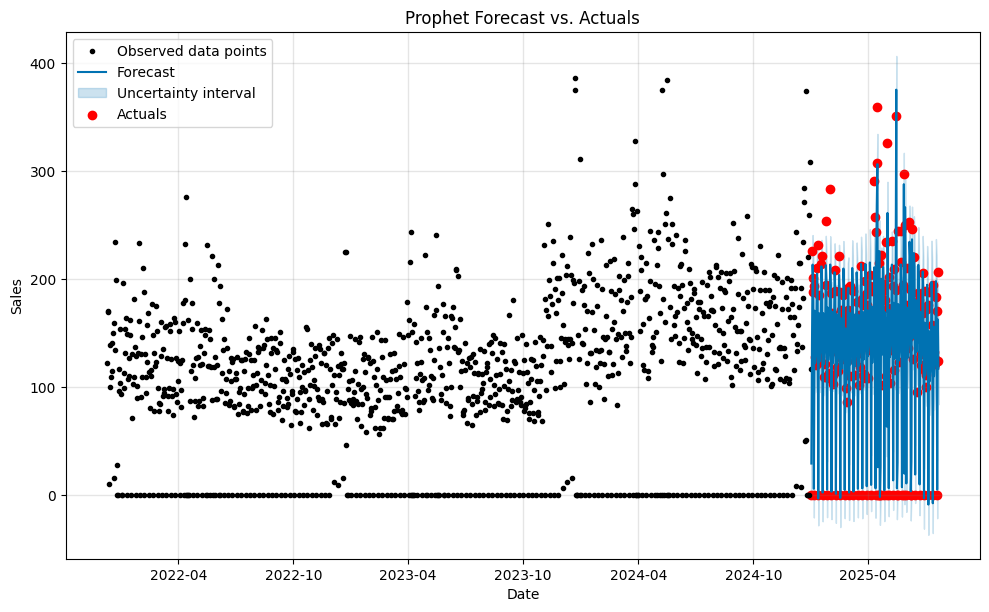


Calling evaluate_prophet_model function (Original Forecast)...

--- Model Evaluation Metrics ---
Metrics are calculated based on the overall performance for the single store (Butikk_ID) included in the analysis.
Comparing Actuals ('y') with Predictions ('yhat') for dates present in the test period (2025 and later).
Mean Absolute Error (MAE): 16.67
Mean Squared Error (MSE): 520.57
Root Mean Squared Error (RMSE): 22.82
Mean Absolute Percentage Error (MAPE): 10.41%
-----------------------------

--- Metric Explanations ---
MAE (16.67): The average magnitude of error in sales units. On average, predictions are off by about 16.67 units.
MSE (520.57): The average of the squared errors. Gives more weight to larger errors.
RMSE (22.82): The square root of MSE, in the same units as sales. Represents the typical magnitude of prediction errors (22.82 units).
MAPE (10.41%): The average absolute percentage error. On average, predictions are off by 10.41% relative to the actual sales for days with 

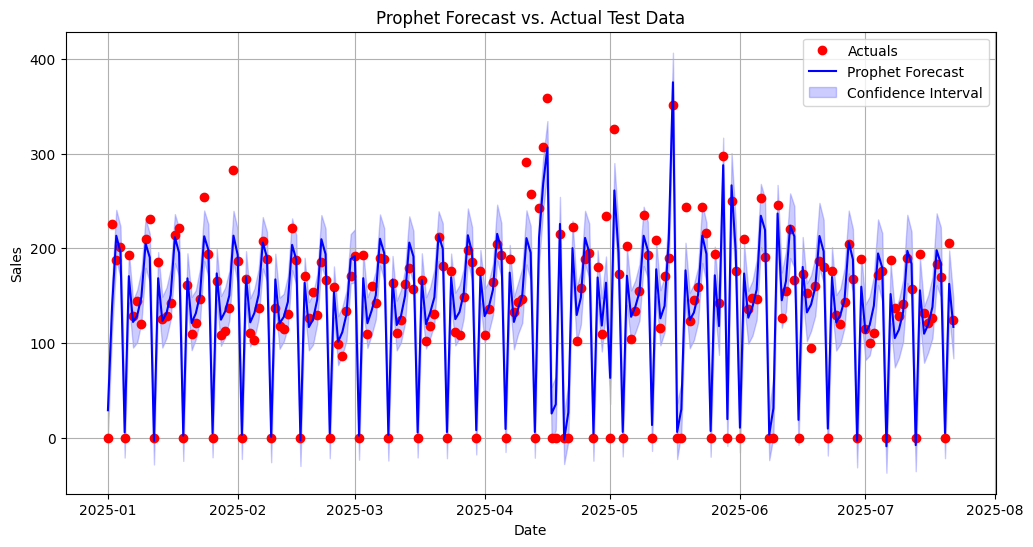


Visualizing forecast components...


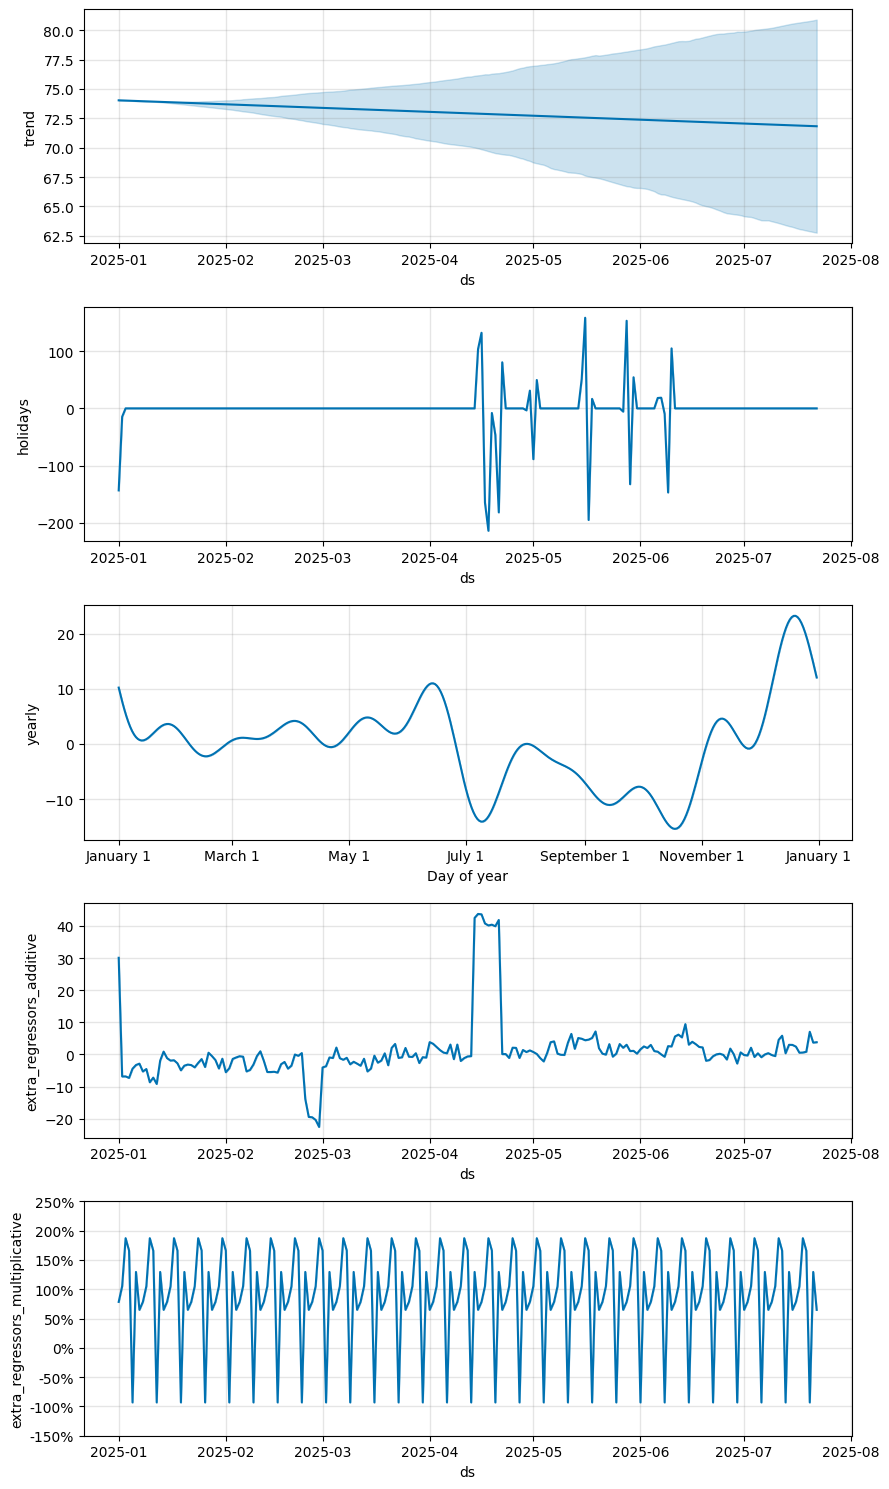


Starting coregation process...

Calling merge_predictions_actuals function...
Actuals and forecast merged.
Daily prediction errors calculated.
Mean prediction errors calculated.
Corected forecast generated.

Calling visualize_forecast_vs_actuals function (Corected Forecast Separate Plot and Components)...
Note: Confidence intervals not available for plotting (e.g., for coregated forecast).


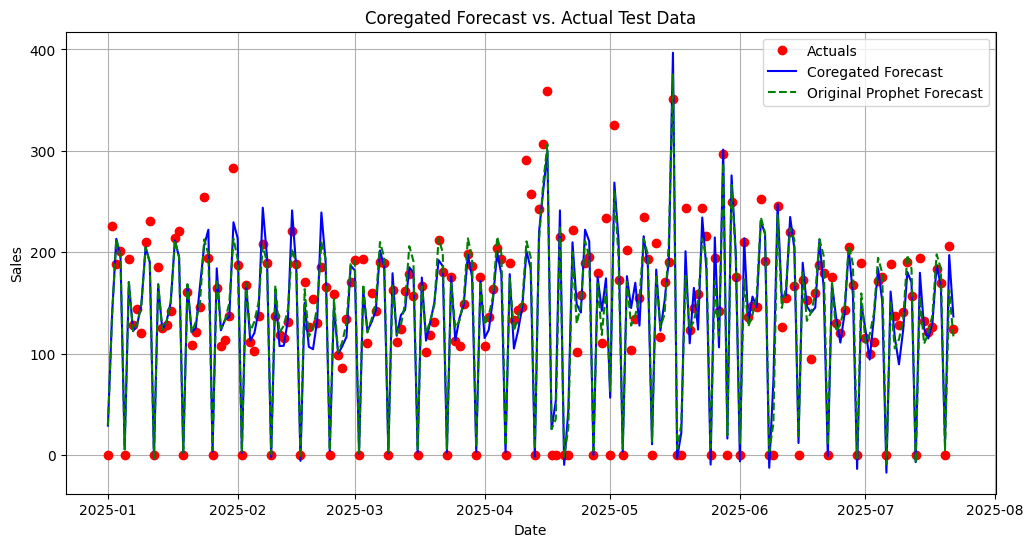


Skipping component plot for coregated forecast (components are from the original model).

Calling evaluate_prophet_model function (Corected Forecast)...

--- Model Evaluation Metrics ---
Metrics are calculated based on the overall performance for the single store (Butikk_ID) included in the analysis.
Comparing Actuals ('y') with Predictions ('coregated_yhat') for dates present in the test period (2025 and later).
Mean Absolute Error (MAE): 17.67
Mean Squared Error (MSE): 591.07
Root Mean Squared Error (RMSE): 24.31
Mean Absolute Percentage Error (MAPE): 11.04%
-----------------------------

--- Metric Explanations ---
MAE (17.67): The average magnitude of error in sales units. On average, predictions are off by about 17.67 units.
MSE (591.07): The average of the squared errors. Gives more weight to larger errors.
RMSE (24.31): The square root of MSE, in the same units as sales. Represents the typical magnitude of prediction errors (24.31 units).
MAPE (11.04%): The average absolute per

In [43]:
# --- Main part of the script ---
print("Starting the end-to-end data preparation, modeling, and visualization process...")

# Set this variable to True to enable verbose output from helper functions, False to suppress it
VerboseBool = True

# 1. Prepare sales data using the function
print("Calling prepare_sales_data function...")
df_prepared = prepare_sales_data('MB salg.xlsx', 'Ark1', verbose=VerboseBool)

# 2. Check if df_prepared is not empty
if df_prepared.empty:
    print("\nError: Sales data preparation failed or returned an empty DataFrame. Cannot proceed.")
else:
    print("\nSales data preparation completed successfully.")

    # 3. Add regressors (weekdays, weather, and holidays)
    print("Calling add_regressors function...")
    # add_regressors now loads and merges weather data and adds holidays internally
    df_prepared_with_regressors = add_regressors(df_prepared.copy(), verbose=VerboseBool)


    # Check if add_regressors was successful and returned a non-empty DataFrame
    if df_prepared_with_regressors.empty:
        print("\nError: Adding regressors failed or returned an empty DataFrame. Cannot proceed with modeling.")
    else:
        print("\nAdding regressors completed successfully.")

        # 4. Split data using the function
        print("Calling split_data function...")
        # Use the DataFrame with all regressors for splitting
        # split_data does not have a verbose parameter, so no change here
        train_df, test_df = split_data(df_prepared_with_regressors)

        # 5. Print row counts for confirmation
        print(f"\nNumber of rows in the training set (before 2025): {len(train_df)}")
        print(f"Number of rows in the test set (2025 and later): {len(test_df)}")

        if train_df.empty or test_df.empty:
            print("\nError: Data splitting resulted in empty training or test sets. Cannot proceed with modeling.")
        else:
            # 6. Train Prophet model using the function
            print("\nCalling train_prophet_model function...")
            # train_prophet_model does not have a verbose parameter, so no change here
            # Note: Holidays should now be handled within add_regressors or passed explicitly if train_prophet_model is updated to accept them
            # Assuming train_prophet_model will use regressors already in the DataFrame
            prophet_model = train_prophet_model(train_df) # No holidays_df parameter needed if holidays are added as regressors in train_df
            print("Prophet model trained.")

            # 7. Generate predictions for the test period using the function
            print("\nCalling generate_prophet_predictions function...")
            # Ensure test_df contains all necessary regressors for prediction
            # generate_prophet_predictions does not have a verbose parameter, so no change here
            forecast = generate_prophet_predictions(prophet_model, test_df)
            print("Predictions generated for the test period.")

            # 8. Print first and last 5 rows of the forecast (specific columns)
            print("\nFirst 5 rows of the forecast (ds, yhat, yhat_lower, yhat_upper):")
            display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
            print("\nLast 5 rows of the forecast (ds, yhat', yhat_lower', yhat_upper'):")
            display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

            # 9. Visualize the overall results (forecast vs. historical and actuals)
            print("\nCalling visualize_prophet_results function (Overall Plot)...")
            visualize_prophet_results(prophet_model, forecast, test_df, verbose=VerboseBool)

            # 10. Evaluate the model's accuracy (Original Forecast)
            print("\nCalling evaluate_prophet_model function (Original Forecast)...")
            evaluate_prophet_model(test_df, forecast, verbose=VerboseBool)

            # 11. Visualize forecast vs. actuals in a separate plot and components (Original Forecast)
            print("\nCalling visualize_forecast_vs_actuals function (Original Forecast Separate Plot and Components)...")
            visualize_forecast_vs_actuals(test_df, forecast, verbose=VerboseBool)

            # --- Coregation Steps ---
            print("\nStarting coregation process...")

            # Step 1: Merge actuals and forecast
            print("\nCalling merge_predictions_actuals function...")
            merged_performance_df = merge_predictions_actuals(test_df, forecast)
            print("Actuals and forecast merged.")

            if not merged_performance_df.empty:
                # Step 2: Calculate daily prediction errors
                merged_performance_df['prediction_error'] = merged_performance_df['y'] - merged_performance_df['yhat']
                print("Daily prediction errors calculated.")

                #step 3 make mean_error_df
                mean_error_df = calculate_mean_error(merged_performance_df)
                print("Mean prediction errors calculated.")

                #step 4 sammenslå mean_error og forcast til corected_forecast
                merged_performance_df['coregated_yhat'] = forecast['yhat'] + mean_error_df['mean_error']
                print("Corected forecast generated.")

                # Step 5: Visualize corected forecast vs. actuals and evaluate
                print("\nCalling visualize_forecast_vs_actuals function (Corected Forecast Separate Plot and Components)...")
                visualize_forecast_vs_actuals(test_df,merged_performance_df, verbose=VerboseBool)
                print("\nCalling evaluate_prophet_model function (Corected Forecast)...")
                evaluate_prophet_model(test_df, merged_performance_df, verbose=VerboseBool)


**Reasoning**:
Define a function to load and prepare the weather data from the specified Excel file.



**Reasoning**:
I will define the `merge_weather_data` sub-function within `add_regressors`, modify `add_regressors` to accept `weather_df`, call the sub-function after adding the weekday regressor, and return the merged DataFrame. I will also update the docstring.



# Ny del: Heligdager

In [31]:
import pandas as pd
from prophet import Prophet
from datetime import date, timedelta
from dateutil.easter import easter # Et nyttig verktøy for å beregne påskedatoer

def generate_norwegian_holidays(start_year: int, end_year: int, custom_holidays: pd.DataFrame = None) -> pd.DataFrame:
    """
    Genererer en Pandas DataFrame med norske helligdager (faste og varierende)
    for en gitt årsrekke, inkludert vinduer for effekt før og etter.
    Kan også inkludere en valgfri DataFrame med egendefinerte helligdager.

    Args:
        start_year (int): Startåret for å generere helligdager.
        end_year (int): Sluttåret for å generere helligdager (inkluderende).
        custom_holidays (pd.DataFrame, optional): En DataFrame med egendefinerte
            helligdager med kolonner 'holiday', 'ds', 'lower_window', 'upper_window'.
            Defaults to None.

    Returns:
        pd.DataFrame: En DataFrame med kolonner 'holiday', 'ds', 'lower_window', 'upper_window'.
                      Helligdagene er sortert etter dato.
    """

    all_holidays_list = []

    # Definer vindusparametere som ønsket
    lower_window_days = -2
    upper_window_days = 1

    for year in range(start_year, end_year + 1):
        # --- Faste helligdager ---
        fixed_holidays = [
            (f'{year}-01-01', '1. nyttårsdag'),
            (f'{year}-05-01', '1. mai'),
            (f'{year}-05-17', 'Grunnlovsdagen'),
            (f'{year}-12-25', '1. juledag'),
            (f'{year}-12-26', '2. juledag'),
        ]

        for date_str, name in fixed_holidays:
            all_holidays_list.append({
                'holiday': name,
                'ds': pd.to_datetime(date_str), # These are already Timestamps
                'lower_window': lower_window_days,
                'upper_window': upper_window_days
            })

        # --- Varierende helligdager (basert på påske) ---
        easter_sunday = easter(year) # Finner dato for 1. påskedag

        # Skjærtorsdag: 2 dager før 1. påskedag
        all_holidays_list.append({
            'holiday': 'Skjærtorsdag',
            'ds': pd.Timestamp(easter_sunday - timedelta(days=3)), # Convert to Timestamp
            'lower_window': lower_window_days,
            'upper_window': upper_window_days
        })
        # Langfredag: 1 dag før 1. påskedag
        all_holidays_list.append({
            'holiday': 'Langfredag',
            'ds': pd.Timestamp(easter_sunday - timedelta(days=2)), # Convert to Timestamp
            'lower_window': lower_window_days,
            'upper_window': upper_window_days
        })
        # 1. påskedag
        all_holidays_list.append({
            'holiday': '1. påskedag',
            'ds': pd.Timestamp(easter_sunday), # Convert to Timestamp
            'lower_window': lower_window_days,
            'upper_window': upper_window_days
        })
        # 2. påskedag
        all_holidays_list.append({
            'holiday': '2. påskedag',
            'ds': pd.Timestamp(easter_sunday + timedelta(days=1)), # Convert to Timestamp
            'lower_window': lower_window_days,
            'upper_window': upper_window_days
        })

        # Kristi Himmelfartsdag: 39 dager etter 1. påskedag
        all_holidays_list.append({
            'holiday': 'Kristi Himmelfartsdag',
            'ds': pd.Timestamp(easter_sunday + timedelta(days=39)), # Convert to Timestamp
            'lower_window': lower_window_days,
            'upper_window': upper_window_days
        })

        # 1. pinsedag: 49 dager etter 1. påskedag
        all_holidays_list.append({
            'holiday': '1. pinsedag',
            'ds': pd.Timestamp(easter_sunday + timedelta(days=49)), # Convert to Timestamp
            'lower_window': lower_window_days,
            'upper_window': upper_window_days
        })
        # 2. pinsedag: 50 dager etter 1. påskedag
        all_holidays_list.append({
            'holiday': '2. pinsedag',
            'ds': pd.Timestamp(easter_sunday + timedelta(days=50)), # Convert to Timestamp
            'lower_window': lower_window_days,
            'upper_window': upper_window_days
        })


    # Konverter liste av dikter til DataFrame
    all_holidays_df = pd.DataFrame(all_holidays_list)

    # --- Legg til egendefinerte helligdager hvis de er oppgitt ---
    if custom_holidays is not None and not custom_holidays.empty:
        # Valider at custom_holidays har de nødvendige kolonnene
        required_cols = ['holiday', 'ds', 'lower_window', 'upper_window']
        if not all(col in custom_holidays.columns for col in required_cols):
             print("Warning: custom_holidays DataFrame does not have the required columns. Skipping custom holidays.")
        else:
            # Konkatenér de to DataFrames
            all_holidays_df = pd.concat([all_holidays_df, custom_holidays], ignore_index=True)
            print(f"Added {len(custom_holidays)} custom holidays.")


    # Sorter etter dato for å holde orden og unngå potensielle problemer
    all_holidays_df = all_holidays_df.sort_values(by='ds').reset_index(drop=True)

    return all_holidays_df


start_year_data = 2020
end_year_forecast = 2028

# The following lines are just for demonstrating the function's output here:
# Define sample custom holidays for demonstration
sample_custom_holidays_list = [
]
if not sample_custom_holidays_list:
    print("Warning: sample_custom_holidays_list is empty. Skipping custom holidays.")
else:
  sample_custom_holidays_df = pd.DataFrame(sample_custom_holidays_list)
  sample_custom_holidays_df['ds'] = pd.to_datetime(sample_custom_holidays_df['ds'])


norwegian_holidays_with_custom = generate_norwegian_holidays(start_year_data, end_year_forecast)


print("Genererte norske helligdager med vinduer (inkludert eksempler på egendefinerte):")
print(norwegian_holidays_with_custom.head(20)) # Print more to show custom holidays
print(f"\nAntall unike helligdager generert: {len(norwegian_holidays_with_custom['holiday'].unique())}")
print(f"Totalt antall helligdagsdatoer generert: {len(norwegian_holidays_with_custom)}")

Genererte norske helligdager med vinduer (inkludert eksempler på egendefinerte):
                  holiday         ds  lower_window  upper_window
0           1. nyttårsdag 2020-01-01            -2             1
1            Skjærtorsdag 2020-04-09            -2             1
2              Langfredag 2020-04-10            -2             1
3             1. påskedag 2020-04-12            -2             1
4             2. påskedag 2020-04-13            -2             1
5                  1. mai 2020-05-01            -2             1
6          Grunnlovsdagen 2020-05-17            -2             1
7   Kristi Himmelfartsdag 2020-05-21            -2             1
8             1. pinsedag 2020-05-31            -2             1
9             2. pinsedag 2020-06-01            -2             1
10             1. juledag 2020-12-25            -2             1
11             2. juledag 2020-12-26            -2             1
12          1. nyttårsdag 2021-01-01            -2             1
13       

# Add regressors

In [32]:
import pandas as pd

# Modified add_regressors to make weather_df and holidays_df optional and call generate_weekday_sequence
def add_regressors(df, verbose=True):
    """
    Adds regressor columns, including weekday, weather, and holiday data,
    to the DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.
        verbose (bool): If True, print progress messages from helper functions. Defaults to True.

    Returns:
        pd.DataFrame: The DataFrame with added regressor columns and merged data.
                      Returns an empty DataFrame if merging fails critically.
    """
    if df.empty:
        print("Warning: Input DataFrame to add_regressors is empty.") # Always print warnings
        return df

    if verbose:
        print("Adding weekday regressors...")
    # Call generate_weekday_sequence to add the 'weekday' and binary columns
    df = generate_weekday_sequence(df, verbose=verbose)
    if verbose:
        print("Weekday regressors added.")


    if verbose:
        print("\nLoading and merging weather data...")
    # Call the sub-function to merge weather data if provide
    # Pass verbose flag to load_weather_data and merge_weather_data
    weather_df = load_weather_data('værtabell.xlsx', verbose=verbose)
    df = merge_weather_data(df, weather_df, verbose=verbose)
    if verbose:
        print("Weather data processed and merged.")


    if verbose:
        print("\nAdding school holiday regressors...")
    # Add school holiday columns using the new function
    df = legg_til_ferie_kolonner(df, verbose=verbose)
    if verbose:
        print("School holiday regressors added.")


    # Return the final DataFrame with all added regressors
    return df


# Example usage (will be called from the main script)
# print("\nApplying add_regressors function with weather and holiday data...")
# try:
#     # Assuming load_weather_data and load_holidays_data have been called
#     # df_prepared_with_all_regressors = add_regressors(df_prepared.copy(), weather_df, holidays_df)
#     # if not df_prepared_with_all_regressors.empty:
#     #     print("\nFirst 5 rows of df_prepared_with_all_regressors:")
#     #     display(df_prepared_with_all_regressors.head())
#     #     print("\nInformation about df_prepared_with_all_regressors:")
#     #     display(df_prepared_with_all_regressors.info())
#     # else:
#     #     print("add_regressors function returned an empty DataFrame.")
#     pass # This will be called from the main script now
# except NameError:
#     print("df_prepared, weather_df, or holidays_df is not defined.")
# except Exception as e:
#      print(f"An error occurred during the example usage of add_regressors: {e}")

In [33]:
  # --- Define the merge_weather_data sub-function ---
  def merge_weather_data(df_to_merge, weather_df, verbose=True):
      """
      Merges the main DataFrame with weather data based on the date.

      Args:
          df_to_merge (pd.DataFrame): The DataFrame to merge (should have 'ds').
          weather_df (pd.DataFrame): The DataFrame with weather data (should have 'ds').
          verbose (bool): If True, print progress messages. Defaults to True.

      Returns:
          pd.DataFrame: The merged DataFrame, or the original DataFrame if merge fails.
      """
      if verbose:
        print("\nAttempting to merge sales data with weather data...")
      if weather_df is None or weather_df.empty:
            print("Warning: Weather DataFrame provided to merge_weather_data is None or empty. Skipping merge.") # Always print warnings
            return df_to_merge # Return the original DataFrame if no weather data

      try:
          # Ensure 'ds' in weather_df is also datetime for merging
          if 'ds' not in weather_df.columns:
                print("Error: Weather DataFrame does not have a 'ds' column for merging.") # Always print errors
                return df_to_merge # Return original if no 'ds' in weather_df

          if not pd.api.types.is_datetime64_any_dtype(weather_df['ds']):
              weather_df['ds'] = pd.to_datetime(weather_df['ds'])

          # Identify weather columns to merge (all except 'ds')
          weather_cols_to_merge = [col for col in weather_df.columns if col != 'ds']
          if not weather_cols_to_merge:
              print("Warning: No weather columns found in weather_df to merge.") # Always print warnings
              return df_to_merge # Return original if no weather columns

          # Perform the merge using a left join to keep all sales dates
          merged_df = pd.merge(df_to_merge, weather_df[['ds'] + weather_cols_to_merge], on='ds', how='left')

          if merged_df.empty:
                print("Warning: Merge resulted in an empty DataFrame.") # Always print warnings
          elif verbose:
              print("Merge successful.")
              print("\nFirst 5 rows of the merged DataFrame:")
              display(merged_df.head())
              print("\nLast 5 rows of the merged DataFrame:")
              display(merged_df.tail())
              print("\nInformation about the merged DataFrame:")
              display(merged_df.info())


          return merged_df
      except Exception as e:
          print(f"An error occurred during weather data merge: {e}") # Always print errors
          return df_to_merge # Return original DataFrame on error
  # --- End of merge_weather_data sub-function ---

In [34]:
import pandas as pd

def load_weather_data(file_path, verbose=True):
    """
    Loads, processes, and cleans weather data from an Excel file.

    Args:
        file_path (str): The path to the Excel file containing weather data.
        verbose (bool): If True, print progress messages. Defaults to True.

    Returns:
        pd.DataFrame: The processed DataFrame with relevant columns,
                      datetime index, and handled missing values,
                      or an empty DataFrame if an error occurred.
    """
    try:
        # Step 2: Load data, interpreting "-" as missing values
        # Use header=0 if the first row is the header
        weather_df_raw = pd.read_excel(file_path, na_values="-", header=0)
        if verbose:
            print(f"Weather data loaded from '{file_path}'.")

        # Step 3: Select relevant columns
        relevant_columns = [
            'Tid(norsk normaltid)',
            'Pent vær (døgn)',
            'Nedbør (døgn)',
            'Middeltemperatur (døgn)',
            'Gjennomsnittlig skydekke (døgn)'
        ]
        # Check if all relevant columns exist before selecting
        missing_cols = [col for col in relevant_columns if col not in weather_df_raw.columns]
        if missing_cols:
            print(f"Error: Missing expected columns in weather data: {missing_cols}") # Always print errors
            return pd.DataFrame()

        weather_df = weather_df_raw[relevant_columns].copy()
        if verbose:
            print("Selected relevant weather columns.")

        # Step 4: Convert date column to datetime, specifying the correct format
        # Based on the error 'time data "13.12.2021" doesn't match format "%m.%d.%Y"',
        # the format might be "%d.%m.%Y"
        weather_df['Tid(norsk normaltid)'] = pd.to_datetime(weather_df['Tid(norsk normaltid)'], format='%d.%m.%Y', errors='coerce')
        if verbose:
            print("Converted 'Tid(norsk normaltid)' to datetime with specified format.")

        # Drop rows where date conversion failed
        weather_df.dropna(subset=['Tid(norsk normaltid)'], inplace=True)

        # Rename the date column for consistency with other dataframes
        weather_df.rename(columns={'Tid(norsk normaltid)': 'ds'}, inplace=True)


        # Step 5: Print missing value counts
        if verbose:
            print("\nMissing values before handling:")
            print(weather_df.isnull().sum())

        # Step 6: Fill missing values in 'Pent vær (døgn)' with 0
        if 'Pent vær (døgn)' in weather_df.columns:
             weather_df['Pent vær (døgn)'].fillna(0, inplace=True)
             if verbose:
                print("\nFilled missing values in 'Pent vær (døgn)' with 0.")
        else:
            print("Warning: 'Pent vær (døgn)' column not found for filling.") # Always print warnings


        # Step 7: Fill missing values in other relevant columns with their mean
        cols_to_fill_mean = [
            'Nedbør (døgn)',
            'Middeltemperatur (døgn)',
            'Gjennomsnittlig skydekke (døgn)'
        ]
        for col in cols_to_fill_mean:
            if col in weather_df.columns:
                mean_value = weather_df[col].mean()
                weather_df[col].fillna(mean_value, inplace=True)
                if verbose:
                    print(f"Filled missing values in '{col}' with the mean ({mean_value:.2f}).")
            else:
                print(f"Warning: '{col}' column not found for filling.") # Always print warnings


        # Verify missing values are filled
        if verbose:
            print("\nMissing values after handling:")
            print(weather_df.isnull().sum())

        if not weather_df.empty and verbose:
            print("\nProcessed weather DataFrame:")
            display(weather_df.head())
            display(weather_df.tail())
            print("\nInformation about weather_df:")
            display(weather_df.info())
        elif weather_df.empty:
             print("\nProcessed weather DataFrame is empty.") # Always print critical issues


        # Step 8: Return the processed DataFrame
        return weather_df

    except FileNotFoundError:
        print(f"Error: Weather file '{file_path}' not found.") # Always print errors
        return pd.DataFrame()
    except KeyError as e:
        print(f"Error: Missing expected column in weather data processing - {e}") # Always print errors
        return pd.DataFrame()
    except Exception as e:
        print(f"An unexpected error occurred while processing weather data: {e}") # Always print errors
        return pd.DataFrame()

# Example usage (will be called in the main script)
# print("Starting weather data loading and preparation...")
# weather_df = load_weather_data('værtabell.xlsx')
#
# if not weather_df.empty:
#     print("\nWeather data preparation completed successfully.")
# else:
#     print("\nWeather data preparation failed.")

In [35]:
import pandas as pd

# Modified generate_weekday_sequence to take a DataFrame and add the 'weekday' column
def generate_weekday_sequence(df, verbose=True):
    """
    Adds a sequence of weekdays (0-6) and binary weekday columns (is_monday, etc.)
    to the DataFrame based on the 'ds' column.

    Args:
        df (pd.DataFrame): The input DataFrame with a 'ds' column (datetime).
        verbose (bool): If True, print progress messages. Defaults to True.

    Returns:
        pd.DataFrame: The DataFrame with the 'weekday' and binary weekday columns added.
    """
    if df.empty:
        print("Warning: Input DataFrame to generate_weekday_sequence is empty.") # Always print warnings
        return df

    # Ensure the 'ds' column is datetime type
    if not pd.api.types.is_datetime64_any_dtype(df['ds']):
        df['ds'] = pd.to_datetime(df['ds'])

    # Extract the weekday (Monday=0, Sunday=6) from each date
    # Corrected: Access .weekday directly from the DatetimeIndex
    df['weekday'] = df['ds'].dt.weekday

    # Add binary columns for each weekday
    weekday_names = ['is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday', 'is_saturday', 'is_sunday']
    for i, day_name in enumerate(weekday_names):
        df[day_name] = (df['weekday'] == i).astype(int)


    if verbose:
        print(f"Added 'weekday' regressor column and binary weekday columns to the DataFrame. First few rows:")
        display(df.head())

    return df

In [36]:
def legg_til_ferie_kolonner(df: pd.DataFrame, verbose=True) -> pd.DataFrame:
    """
    Legger til binære kolonner for skoleferier i Stavanger (2021-2025)
    i en dataframe.

    Args:
        df: En pandas DataFrame som må inneholde en 'ds'-kolonne med datoer.
        verbose (bool): If True, print progress messages. Defaults to True.

    Returns:
        En DataFrame med lagt til feriekolonner.
    """
    # Ensure the 'ds' column is in datetime format
    if not pd.api.types.is_datetime64_any_dtype(df['ds']):
        df['ds'] = pd.to_datetime(df['ds'], errors='coerce')
        # Handle cases where conversion might fail if necessary
        df.dropna(subset=['ds'], inplace=True)


    # Definerer ferieperiodene for Stavanger
    # Merk: Juleferier strekker seg over årsskiftet, så vi behandler dem som '2021/2022', etc.
    ferier = {
        'sommerferie': [
            ('2021-06-25', '2021-08-16'),
            ('2022-06-24', '2022-08-17'),
            ('2023-06-23', '2023-08-16'),
            ('2024-06-20', '2024-08-14'),
            ('2025-06-20', '2025-08-13')
        ],
        'høstferie': [
            ('2021-10-11', '2021-10-15'),
            ('2022-10-10', '2022-10-14'),
            ('2023-10-09', '2023-10-13'),
            ('2024-10-07', '2024-10-11')
        ],
        'juleferie': [
            ('2021-12-22', '2022-01-02'),
            ('2022-12-22', '2023-01-02'),
            ('2023-12-21', '2024-01-03'),
            ('2024-12-20', '2025-01-01')
        ],
        'vinterferie': [
            ('2022-02-28', '2022-03-04'),
            ('2023-02-27', '2023-03-03'),
            ('2024-02-26', '2024-03-01'),
            ('2025-02-24', '2025-02-28')
        ],
        'påskeferie': [
            ('2022-04-11', '2022-04-18'),
            ('2023-04-03', '2023-04-11'),
            ('2024-03-25', '2024-04-01'),
            ('2025-04-14', '2025-04-21')
        ]
    }

    # Initialiserer feriekolonnene med 0
    for ferietype in ferier.keys():
        df[ferietype] = 0

    # Itererer gjennom hver ferietype og setter verdien til 1 for feriedatoer
    for ferietype, perioder in ferier.items():
        for start_str, slutt_str in perioder:
            start_dato = pd.to_datetime(start_str)
            slutt_dato = pd.to_datetime(slutt_str)
            df.loc[(df['ds'] >= start_dato) & (df['ds'] <= slutt_dato), ferietype] = 1

    if verbose:
        print(f"Added school holiday columns to the DataFrame.")
        # Optionally display head/info here if verbose is True

    return df

# --- Eksempel på bruk av funksjonen ---
# Oppretter en dummy dataframe
# data = {
#     'ds': ['2023-10-08', '2023-10-10', '2024-02-20', '2024-02-27'],
#     'y': [100, 50, 200, 75]
# }
# dummy_df = pd.DataFrame(data)

# Kaller funksjonen for å legge til feriekolonner
# df_med_ferier = legg_til_ferie_kolonner(dummy_df.copy())

# print(df_med_ferier)

# Task
Create a Python function `calculate_weekly_growth(weekly_aggregated_df)` that takes a DataFrame with weekly aggregated sales data, calculates the average sales per week across all years, and then computes the percentage growth from each week to the next, handling the year-end transition. The function should return a structure showing the week number and the calculated percentage growth. Test the function with the weekly aggregated data.

In [37]:
import pandas as pd

def prepare_sales_data_product(file_path, sheet_name, product_row, verbose=True):
    """
    Prepares product sales data from an Excel file for Prophet modeling.
    Handles a different file structure: Product ID in column 3, data from row 6.
    Retains NaN values for dates without sales.

    Args:
        file_path (str): The path to the Excel file.
        sheet_name (str): The name of the sheet to read from.
        product_row (int): The row index (0-based) where the product data starts.
        verbose (bool): If True, print progress messages. Defaults to True.


    Returns:
        pd.DataFrame: The prepared DataFrame with 'ds', 'y', and 'Product_ID' columns,
                      or an empty DataFrame if an error occurred.
    """
    df_full_raw = None
    try:
        df_full_raw = pd.read_excel(file_path, sheet_name=sheet_name, header=None)
        if verbose:
            print(f"Excel file '{file_path}' loaded.")
    except FileNotFoundError:
        print(f"Error: '{file_path}' not found.") # Always print errors
        return pd.DataFrame(columns=['ds', 'y', 'Product_ID'])
    except Exception as e:
        print(f"An error occurred while loading the Excel file: {e}") # Always print errors
        return pd.DataFrame(columns=['ds', 'y', 'Product_ID'])

    if df_full_raw is not None and not df_full_raw.empty:
        # --- Identify date columns and sales data rows ---
        # Assuming dates are in the SECOND row (index 1), from column 3 onwards.
        # Assuming product data starts from row 6 (index 5) onwards.
        # Assuming the first product data is in row 6 (index 5) in the raw data.

        # --- Manual Date Range Creation (adapted from prepare_sales_data) ---
        # Attempt to read the start and end dates from the raw data if available, otherwise use hardcoded fallbacks.
        start_date_from_file = None
        end_date_from_file = None

        try:
            # Attempt to read the start date from the specified cell (B2 -> iloc[1, 1])
            raw_start_date_value = df_full_raw.iloc[1, 1]
            # Attempt to read the end date from the last date column D2 (iloc[1, 3])
            raw_end_date_value = df_full_raw.iloc[1, 3]

            # Try to parse these values into datetime objects
            if pd.notna(raw_start_date_value):
                if isinstance(raw_start_date_value, pd.Timestamp):
                    start_date_from_file = raw_start_date_value.strftime('%Y-%m-%d')
                else:
                    try:
                        # Assuming day/month/year format or similar common variations
                        start_date_from_file = pd.to_datetime(str(raw_start_date_value).split(' ')[0], errors='coerce').strftime('%Y-%m-%d')
                    except:
                         print(f"Warning: Could not parse start date '{raw_start_date_value}'. Using fallback.") # Always print warnings
                         start_date_from_file = '2021-12-09' # Fallback

            if pd.notna(raw_end_date_value):
                 if isinstance(raw_end_date_value, pd.Timestamp):
                    end_date_from_file = raw_end_date_value.strftime('%Y-%m-%d')
                 else:
                    try:
                        # Assuming day/month/year format or similar common variations
                        end_date_from_file = pd.to_datetime(str(raw_end_date_value).split(' ')[0], errors='coerce').strftime('%Y-%m-%d')
                    except:
                         print(f"Warning: Could not parse end date '{raw_end_date_value}'. Using fallback.") # Always print warnings
                         end_date_from_file = '2025-07-22' # Fallback

        except IndexError:
            print("Warning: Could not access expected date cells. Using fallback dates.") # Always print warnings
            start_date_from_file = '2021-12-09'
            end_date_from_file = '2025-07-22'
        except Exception as e:
             print(f"An unexpected error occurred while trying to read dates: {e}. Using fallback dates.") # Always print errors
             start_date_from_file = '2021-12-09'
             end_date_from_file = '2025-07-22'


        start_date_manual = start_date_from_file if start_date_from_file else '2021-12-09'
        end_date_manual = end_date_from_file if end_date_from_file else '2025-07-22'


        if verbose:
            print(f"Creating date range from {start_date_manual} to {end_date_manual}...")
        full_date_range = pd.date_range(start=start_date_manual, end=end_date_manual, freq='D')
        full_date_range_df = pd.DataFrame({'ds': full_date_range})
        if verbose:
            print(f"Created date range with {len(full_date_range_df)} days.")


        # --- Extract raw sales data for the first product ---
        # Product data starts from row 6 (index 5)
        if len(df_full_raw) > product_row: # Check that there are enough rows for product data
            first_product_row = df_full_raw.iloc[product_row] # Get the row for the first product
            selected_product_id = first_product_row.iloc[2] # Product ID is in column 3 (index 2)

            # Sales data starts from original column 3 (index 3 in the raw DataFrame)
            sales_data_for_selected_product_raw = first_product_row.iloc[3:]

            if verbose:
                print(f"Extracted {len(sales_data_for_selected_product_raw)} raw sales data points for product ID {selected_product_id}.")

            # Convert to numeric, set errors to NaN. DO NOT fill NaN with 0 here.
            numeric_sales_data = pd.to_numeric(sales_data_for_selected_product_raw, errors='coerce')

            # IMPORTANT: Reset the index of the sales data so it matches the date range's RangeIndex
            numeric_sales_data = numeric_sales_data.reset_index(drop=True)

            # --- Combine date range and sales data ---
            if len(numeric_sales_data) != len(full_date_range_df):
                print(f"Critical Warning: Number of sales data points ({len(numeric_sales_data)}) does NOT match the number of days in the date range ({len(full_date_range_df)}). Cannot proceed with data prep.") # Always print warnings
                return pd.DataFrame(columns=['ds', 'y', 'Product_ID'])
            else:
                df_prepared = pd.DataFrame({
                    'ds': full_date_range_df['ds'],
                    'y': numeric_sales_data # Use the numeric data with NaNs
                })

            # --- Add Product_ID ---
            df_prepared['Product_ID'] = selected_product_id

            # --- Validation ---
            if verbose:
                print("\nPrepared DataFrame (df_prepared) with manual date range:")
                print(df_prepared.head())
                print("\nInformation about df_prepared:")
                df_prepared.info()
                print("\nChecking for missing values in df_prepared:")
                print(df_prepared.isnull().sum()) # Show NaN counts


            if verbose:
                print("\n'df_prepared' for product sales is now ready with manual date range.")
            return df_prepared

        else:
            print("Error: 'df_full_raw' does not have enough rows to extract product data.") # Always print errors
            return pd.DataFrame(columns=['ds', 'y', 'Product_ID'])

    else:
        print("Product data preparation could not be completed due to errors loading the file or empty raw data.") # Always print errors
        return pd.DataFrame(columns=['ds', 'y', 'Product_ID'])


# Example usage (replace with your actual file path and sheet name)
# print("Starting product data preparation using the function...")
# product_df_prepared = prepare_sales_data_product('YourProductSalesFile.xlsx', 'Sheet1') # REPLACE WITH YOUR FILE AND SHEET

# if not product_df_prepared.empty:
#     print("\nProduct data preparation function completed successfully.")
#     print("\nFirst 5 rows of product_df_prepared:")
#     display(product_df_prepared.head())
#     print("\nLast 5 rows of product_df_prepared:")
#     display(product_df_prepared.tail())
#     print("\nInformation about product_df_prepared:")
#     display(product_df_prepared.info())
# else:
#     print("\nProduct data preparation function failed to return a valid DataFrame.")

In [38]:
# Example usage of the new function
# Replace 'YourProductSalesFile.xlsx' and 'Sheet1' with your actual file path and sheet name
# Added verbose=False to suppress detailed output from this specific call if needed
product_df = prepare_sales_data_product('produkter.xlsx', 'Sheet0', 8, verbose=False)

if not product_df.empty:
    print("\nProduct data loaded successfully:")
    display(product_df.head())
    display(product_df.tail())
    display(product_df.info())
else:
    print("\nFailed to load product data.")


Product data loaded successfully:


,ds,y,Product_ID
0,2021-12-09,705.0,2266
1,2021-12-10,817.0,2266
2,2021-12-11,1076.0,2266
3,2021-12-12,NaN,2266
4,2021-12-13,886.0,2266


,ds,y,Product_ID
1317,2025-07-18,431.0,2266
1318,2025-07-19,484.0,2266
1319,2025-07-20,NaN,2266
1320,2025-07-21,610.0,2266
1321,2025-07-22,399.0,2266


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1322 entries, 0 to 1321
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ds          1322 non-null   datetime64[ns]
 1   y           1258 non-null   float64       
 2   Product_ID  1322 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 31.1+ KB


None

## Opprett funksjonen `calculate weekly growth`

### Subtask:
Opprett en ny funksjon `calculate_weekly_growth(weekly_aggregated_df)` som tar inn DataFrame-en med ukentlig aggregerte salgsdata (resultatet fra `aggregate_sales_weekly`).


**Reasoning**:
I have defined the function signature and docstring. Now I need to implement the logic to calculate the average sales per week across all years and then compute the percentage growth between consecutive weeks, handling the year-end transition.



In [40]:
import pandas as pd
import sys # Import sys to use sys.exit

# 1. Prepare sales data using the function
# print("Calling prepare_sales_data function...")
# df = prepare_sales_data('MB salg.xlsx', 'Ark1')

# if df.empty:
#    print("Warning: Input DataFrame to add_regressors is empty.")
#    sys.exit(1)

# 2. Add weekdays
# generate_weekday_sequence now modifies and returns the DataFrame
# df = generate_weekday_sequence(df)

def aggregate_sales_weekly(df, verbose=True):
    """
    Aggregates sales data weekly, calculating the total sales per week.

    Args:
        df (pd.DataFrame): Input DataFrame with 'ds' (datetime) and 'y' (sales) columns.
        verbose (bool): If True, print progress messages. Defaults to True.

    Returns:
        pd.DataFrame: A new DataFrame with 'week_of_year' and 'total_weekly_sales' columns.
                      Returns an empty DataFrame if the input is empty or processing fails.
    """
    if df.empty or 'ds' not in df.columns or 'y' not in df.columns:
        print("Error: Input DataFrame is empty or missing 'ds' or 'y' columns for weekly aggregation.") # Always print errors
        return pd.DataFrame(columns=['year', 'week_of_year', 'total_weekly_sales']) # Added 'year' to returned columns


    try:
        # Ensure 'ds' is datetime type
        if not pd.api.types.is_datetime64_any_dtype(df['ds']):
            df['ds'] = pd.to_datetime(df['ds'])

        # Extract Year and Week of Year (ISO 8601 standard)
        # .dt.isocalendar().week gives the ISO week number (1-53)
        # We need week number 0-52, resetting each year.
        # We can use strftime('%W') which gives week number 00-53, with week 0 starting on the first Monday of the year.
        # Or we can calculate it manually to ensure it aligns with the first week of the dataset.

        # Let's try using .dt.isocalendar().week and adjust it.
        # ISO week 1 starts with the first Thursday of the year.
        # If the first date is in week 49 (as mentioned by the user), ISO week might be suitable or need adjustment.

        # A simpler approach for 0-52 week number resetting each year:
        # Get the week number using %W (week number of the year, Monday as the first day of week 00)
        # Use %W for week number (00-53), Monday as the first day of the week
        df_agg = df.copy()
        df_agg['year'] = df_agg['ds'].dt.year
        df_agg['week_of_year_str'] = df_agg['ds'].dt.strftime('%W')
        df_agg['week_of_year'] = df_agg['week_of_year_str'].astype(int)


        # Group by Year and Week of Year and sum the sales ('y')
        weekly_sales = df_agg.groupby(['year', 'week_of_year'])['y'].sum().reset_index()

        # Rename the sales column for clarity
        weekly_sales.rename(columns={'y': 'total_weekly_sales'}, inplace=True)

        # The user wants week numbers 0-52. %W gives 00-53. This is fine.

        if verbose:
            print("Weekly aggregation completed.")
            display(weekly_sales.head())
            display(weekly_sales.tail())


        # Return the aggregatet dataframe
        return weekly_sales

    except Exception as e:
        print(f"An error occurred during weekly aggregation: {e}") # Always print errors
        return pd.DataFrame(columns=['year', 'week_of_year', 'total_weekly_sales']) # Ensure consistent empty df columns

# Example usage (assuming df_prepared_with_regressors exists)
# print("\nAggregating sales data weekly...")
# try:
#     weekly_aggregated_df = aggregate_sales_weekly(df_prepared_with_regressors.copy())
#     print("\nWeekly aggregated data:")
#     display(weekly_aggregated_df.head())
#     display(weekly_aggregated_df.tail())
#     print("\nInformation about weekly_aggregated_df:")
#     display(weekly_aggregated_df.info())
# except NameError:
#     print("Error: df_prepared_with_regressors is not defined. Run data preparation first.")
# except Exception as e:
#      print(f"An error occurred during example weekly aggregation: {e}")

# weekly_aggregated_df = aggregate_sales_weekly(df_prepared_with_regressors.copy())

def calculate_weekly_growth(weekly_aggregated_df, verbose=True):
    """
    Calculates the weekly growth in sales.

    Args:
        weekly_aggregated_df (pd.DataFrame): A DataFrame with weekly aggregated sales data
                                             containing 'year', 'week_of_year', and 'total_weekly_sales' columns.
        verbose (bool): If True, print progress messages. Defaults to True.


    Returns:
        pd.DataFrame: A DataFrame with 'week_of_year' and 'percentage_growth' columns.
                      Returns an empty DataFrame if input is invalid or calculation fails.
    """
    if weekly_aggregated_df.empty or 'year' not in weekly_aggregated_df.columns or 'week_of_year' not in weekly_aggregated_df.columns or 'total_weekly_sales' not in weekly_aggregated_df.columns:
        print("Error: Input DataFrame is empty or missing required columns for weekly growth calculation.") # Always print errors
        return pd.DataFrame(columns=['week_of_year', 'percentage_growth'])

    try:
        if verbose:
            print("Calculating average sales per week across all years...")
        # Calculate average sales per week across all years
        average_weekly_sales = weekly_aggregated_df.groupby('week_of_year')['total_weekly_sales'].mean().reset_index()
        average_weekly_sales.rename(columns={'total_weekly_sales': 'average_sales'}, inplace=True)

        # Sort by week number to ensure correct sequence for growth calculation
        average_weekly_sales = average_weekly_sales.sort_values(by='week_of_year').reset_index(drop=True)

        # Calculate percentage growth from each week to the next
        # To handle the transition from week 52/53 to week 0, we need to append
        # the first week's average sales to the end of the DataFrame for calculation.

        # Get the average sales for week 0
        if 0 in average_weekly_sales['week_of_year'].values:
             week_0_sales = average_weekly_sales[average_weekly_sales['week_of_year'] == 0]['average_sales'].iloc[0]
             # Append week 0's average sales to the end for calculation from the last week
             temp_sales = average_weekly_sales['average_sales'].tolist() + [week_0_sales]

             # Calculate percentage change: (Current - Previous) / Previous * 100
             # This calculation will produce one extra value for the growth from the last week to week 0.
             # The growth for week 0 is the growth from the last week of the previous year to week 0.
             # The growth for week N (where N > 0) is the growth from week N-1 to week N.

             # Calculate the difference and then percentage change
             diff = pd.Series(temp_sales).diff().iloc[1:].tolist() # Difference from previous, dropping the first NaN
             previous_sales = pd.Series(temp_sales[:-1]) # The denominator for percentage change

             # Avoid division by zero
             percentage_growth = []
             for i in range(len(diff)):
                 if previous_sales.iloc[i] != 0:
                     growth = (diff[i] / previous_sales.iloc[i]) * 100
                 else:
                     # Handle cases where previous week's sales were zero
                     # If current sales are also zero, growth is 0%. If current sales are > 0, growth is infinite/undefined.
                     # For simplicity, let's assign 0 growth if the previous week was zero.
                      growth = 0.0
                 percentage_growth.append(growth)

        else:
             # If week 0 is not in the data, growth calculation from last week to week 0 is not possible in this way
             if verbose:
                print("Warning: Week 0 not found in aggregated data. Skipping calculation of growth from last week to week 0.")
             # Calculate growth only between consecutive weeks present in the data
             average_weekly_sales['percentage_growth'] = average_weekly_sales['average_sales'].pct_change() * 100
             # Fill the first value (which is NaN after pct_change) with 0 or another appropriate value
             average_weekly_sales['percentage_growth'].fillna(0, inplace=True)
             percentage_growth = average_weekly_sales['percentage_growth'].tolist() # Use the calculated percentages

        # Create the result DataFrame
        weekly_growth_df = pd.DataFrame({
            'week_of_year': average_weekly_sales['week_of_year'],
            'percentage_growth': percentage_growth
        })

        if verbose:
            print("\nWeekly growth calculation completed successfully.")
            print("\nWeekly growth results:")
            display(weekly_growth_df)


        return weekly_growth_df

    except Exception as e:
        print(f"An error occurred during weekly growth calculation: {e}") # Always print errors
        return pd.DataFrame(columns=['week_of_year', 'percentage_growth'])

# Test the function with the weekly aggregated data
# print("Calculating weekly growth...")
# try:
#     # Assuming weekly_aggregated_df exists from the previous subtask
#     if 'weekly_aggregated_df' in locals() or 'weekly_aggregated_df' in globals():
#         weekly_growth_results = calculate_weekly_growth(weekly_aggregated_df.copy())

#         if not weekly_growth_results.empty:
#             print("\nWeekly growth calculation completed successfully.")
#             print("\nWeekly growth results:")
#             display(weekly_growth_results)
#             print("\nInformation about weekly_growth_results:")
#             display(weekly_growth_results.info())
#         else:
#             print("\nWeekly growth calculation returned an empty DataFrame.")
#     else:
#         print("Error: weekly_aggregated_df is not defined. Run weekly aggregation first.")

# except Exception as e:
#     print(f"An error occurred during the test of calculate_weekly_growth: {e}")

**Reasoning**:
The previous attempt to test the `calculate_weekly_growth` function failed because `weekly_aggregated_df` was not defined in the current execution environment. I need to call the `aggregate_sales_weekly` function first to create `weekly_aggregated_df` before calling `calculate_weekly_growth`.



# Task

# Task
Create a Python function `coregate_predictions(test_df, forecast)` that takes a DataFrame of actual sales (`test_df`) and a Prophet forecast DataFrame (`forecast`), calculates the prediction error for each day, and then adjusts the current day's forecast based on the average error of the same weekday in the preceding three weeks. The function should return a DataFrame with the date ('ds') and the corrected forecast ('coregated_yhat').

## Merge actuals and forecast

### Subtask:
Combine the actual sales data (`test_df`) with the Prophet forecast (`forecast`) into a single DataFrame based on the date ('ds') to easily compare actuals and predictions.


In [41]:
def merge_predictions_actuals(test_df, forecast):
    """
    Combines actual sales data with Prophet forecast and calculates daily error.

    Args:
        test_df (pd.DataFrame): DataFrame with actual sales ('ds', 'y').
        forecast (pd.DataFrame): DataFrame with Prophet forecast ('ds', 'yhat').

    Returns:
        pd.DataFrame: Merged DataFrame with 'ds', 'y', and 'yhat' columns.
                      Returns an empty DataFrame if merging fails or inputs are invalid.
    """
    if test_df.empty or forecast.empty or 'ds' not in test_df.columns or 'y' not in test_df.columns or 'ds' not in forecast.columns or 'yhat' not in forecast.columns:
        print("Error: Input DataFrames are empty or missing required columns for merging.") # Always print errors
        return pd.DataFrame(columns=['ds', 'y', 'yhat'])

    try:
        # Ensure 'ds' columns are datetime type for merging
        if not pd.api.types.is_datetime64_any_dtype(test_df['ds']):
            test_df['ds'] = pd.to_datetime(test_df['ds'], errors='coerce')
            test_df.dropna(subset=['ds'], inplace=True) # Drop rows where conversion failed

        if not pd.api.types.is_datetime64_any_dtype(forecast['ds']):
             forecast['ds'] = pd.to_datetime(forecast['ds'], errors='coerce')
             forecast.dropna(subset=['ds'], inplace=True) # Drop rows where conversion failed


        # Merge actuals with forecast based on date
        # Use an inner join to keep only dates present in both DataFrames
        merged_df = pd.merge(test_df[['ds', 'y']], forecast[['ds', 'yhat']], on='ds', how='inner')

        if merged_df.empty:
            print("Warning: Merge resulted in an empty DataFrame. No overlapping dates between test_df and forecast.") # Always print warnings


        return merged_df

    except Exception as e:
        print(f"An error occurred during merging test_df and forecast: {e}") # Always print errors
        return pd.DataFrame(columns=['ds', 'y', 'yhat'])

In [42]:
import pandas as pd

def calculate_mean_error(merged_performance_df):
    """
    Calculates the mean prediction error for each date based on the same weekday
    in the preceding three weeks (ds-7, ds-14, ds-21). Sets mean_error to 0 for
    the first 21 days.

    Args:
        merged_performance_df (pd.DataFrame): DataFrame containing 'ds' and 'prediction_error'.

    Returns:
        pd.DataFrame: DataFrame with 'ds' and the calculated 'mean_error' column.
                      Returns an empty DataFrame if input is invalid.
    """
    if merged_performance_df.empty or 'ds' not in merged_performance_df.columns or 'prediction_error' not in merged_performance_df.columns:
        print("Error: Input DataFrame is empty or missing 'ds' or 'prediction_error' columns for mean error calculation.")
        return pd.DataFrame(columns=['ds', 'mean_error'])

    # Ensure 'ds' is datetime and sort by date
    if not pd.api.types.is_datetime64_any_dtype(merged_performance_df['ds']):
        merged_performance_df['ds'] = pd.to_datetime(merged_performance_df['ds'])
    merged_performance_df = merged_performance_df.sort_values(by='ds').reset_index(drop=True)

    # Initialize 'mean_error' column with 0
    merged_performance_df['mean_error'] = 0.0

    # Calculate mean error for dates after the first 21 days
    # Iterate through the DataFrame starting from the 22nd day (index 21)
    for i in range(21, len(merged_performance_df)):
        current_date = merged_performance_df.loc[i, 'ds']
        errors_to_average = []

        # Look back at the same weekday in the previous 3 weeks
        for j in range(1, 4): # Look back 1, 2, and 3 weeks
            previous_date = current_date - pd.Timedelta(days=7 * j)

            # Find the row for the previous date
            previous_row = merged_performance_df[merged_performance_df['ds'] == previous_date]

            if not previous_row.empty:
                # Add the prediction error from the previous date
                errors_to_average.append(previous_row['prediction_error'].iloc[0]) # Use .iloc[0] to get the value

        # Calculate the average error if errors were found
        if errors_to_average:
            merged_performance_df.loc[i, 'mean_error'] = sum(errors_to_average) / len(errors_to_average)
        # If no errors were found in the lookback window (e.g., early dates), mean_error remains 0 (initialized)


    # Return DataFrame with 'ds' and 'mean_error'
    return merged_performance_df[['ds', 'mean_error']].copy()

# Example Usage (replace with your actual merged_performance_df)
# Assuming merged_performance_df is available from previous steps and has 'ds' and 'prediction_error'
# try:
#     if 'merged_performance_df' in locals() or 'merged_performance_df' in globals():
#          mean_error_df_result = calculate_mean_error(merged_performance_df.copy())
#
#          if not mean_error_df_result.empty:
#              print("\nMean error calculation completed successfully.")
#              print("\nMean error DataFrame (first 30 rows):")
#              display(mean_error_df_result.head(30)) # Display more rows to see non-zero errors
#              print("\nMean error DataFrame (tail):")
#              display(mean_error_df_result.tail())
#              print("\nInformation about mean_error_df_result:")
#              display(mean_error_df_result.info())
#          else:
#              print("\nMean error calculation returned an empty DataFrame.")
#     else:
#         print("Error: merged_performance_df is not defined. Run merging step first.")
#
# except Exception as e:
#     print(f"An error occurred during the test of calculate_mean_error: {e}")

# Task
Save Notebook to GitHub: In Google Colab, go to 'File' -> 'Save a copy in GitHub...'. You will need to authenticate your GitHub account if you haven't already. Choose the repository and branch where you want to save the notebook, and provide a commit message.

Verify on GitHub: After saving, navigate to your GitHub repository in a web browser to confirm that the notebook has been successfully pushed and is visible there.

Final Task: Confirm that the notebook is successfully saved to your GitHub repository. This marks the completion of moving your work to GitHub.

## Save Notebook to GitHub

### Subtask:
Save the current Google Colab notebook to a specified GitHub repository.


## Save Notebook to GitHub

### Subtask:
Save the current Google Colab notebook to a specified GitHub repository.

#### Instructions
1. In Google Colab, go to 'File' in the top menu.
2. From the dropdown, select 'Save a copy in GitHub...'.
3. If prompted, authenticate your GitHub account.
4. Choose the desired GitHub repository and branch.
5. Provide a meaningful commit message for the changes.
6. Click 'OK' or 'Save' to initiate the save to GitHub.

## Verify on GitHub

### Subtask:
After saving, navigate to your GitHub repository in a web browser to confirm that the notebook has been successfully pushed and is visible there.


## Verify on GitHub

### Subtask:
After saving, navigate to your GitHub repository in a web browser to confirm that the notebook has been successfully pushed and is visible there.

#### Instructions
1. Open your web browser.
2. Navigate to your GitHub repository where you saved the Google Colab notebook.
3. Browse the repository to confirm that the notebook file is present and visible.
4. Optionally, click on the notebook file to view its content and ensure it reflects the latest changes.


## Final Task

### Subtask:
Confirm that the notebook is successfully saved to your GitHub repository. This marks the completion of moving your work to GitHub.


## Summary:

### Data Analysis Key Findings
*   The primary objective of the task was to guide the user through manually saving a Google Colab notebook to a GitHub repository and subsequently verifying its presence.
*   The first subtask focused on providing detailed, step-by-step instructions for the user to utilize Colab's 'File' -> 'Save a copy in GitHub...' feature, including authentication, repository selection, and commit message entry.
*   The second subtask provided clear instructions for the user to navigate to their GitHub repository via a web browser and confirm the successful push and visibility of the saved notebook file.
*   Both subtasks were successfully completed by generating comprehensive markdown instructions for the user, as the saving and verification actions are manual and external to the agent's direct execution.

### Insights or Next Steps
*   For tasks involving interactions with external platforms like GitHub that require user authentication or manual navigation, providing precise, step-by-step user instructions is an effective solution strategy.
*   Future enhancements could include an interactive verification step where the agent prompts the user to confirm completion of the manual steps, ensuring successful execution from the user's perspective.
